In [62]:
from gensim.models.word2vec import Word2Vec
from sklearn.externals import joblib

In [63]:
from tqdm import tqdm
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler

In [64]:
import sys
import csv
import pandas as pd
import tweepy
import string
from string import maketrans 
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import nltk
wordnet_lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/adityasidharta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/adityasidharta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
wordnet_lemmatizer.lemmatize('cats')

u'cat'

In [7]:
ckey = "QUGIYqjtkYTQzP86gNq4hhIvV"
csecret = "wNZjZTBHcCBrErubiwMbPzQefx6n2VWqXtcfRsdPHOPiMUW7gu"
atoken = "79133617-CfnOP1oJzG0r9r7VX7ZAUX3CHEZtxq62nVxXG6NXC"
asecret = "6tRA4gXj08Q0f2vqjaexe6r90cqCzjfg4FG3vMmzZBVrQ"

In [8]:
auth = tweepy.OAuthHandler(ckey, csecret)
auth.set_access_token(atoken, asecret)
api = tweepy.API(auth)

In [20]:
def get_all_tweets(screen_name):
    alltweets = []
    new_tweets = api.user_timeline(screen_name = screen_name,count=200)
    alltweets.extend(new_tweets)
    oldest = alltweets[-1].id - 1

    while len(new_tweets) > 0:
        new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest)
        alltweets.extend(new_tweets)

        oldest = alltweets[-1].id - 1

    outtweets = [[tweet.id_str, tweet.created_at, tweet.text.encode("utf-8")] for tweet in alltweets]

    with open('%s_tweets.csv' % screen_name, 'wb') as f:
        writer = csv.writer(f)
        writer.writerow(["id","created_at","text"])
        writer.writerows(outtweets)

pass

In [21]:
get_all_tweets('HillaryClinton')
get_all_tweets('RealDonaldTrump')

In [72]:
df_hillary = pd.read_csv('HillaryClinton_tweets.csv')
df_trump = pd.read_csv('realDonaldtrump_tweets.csv')

In [73]:
def text_process(s):
    s = str(s)
    s = s.translate(None, string.punctuation.replace('@',''))
    s = s.translate(None, '1234567890')
    s = [word for word in s.split() if not \
     (word.startswith('http') or word.startswith('@'))]
    s = ' '.join(s)
    s = re.sub(' +',' ',s)
    s = s.decode('ascii', 'ignore')
    s = s.lower()
    s = [word for word in s.split() if word not\
         in stopwords.words('english') + ['rt'] + ['amp'] + ['hillary', 'donald', 'trump' + 'u']]
    s = [wordnet_lemmatizer.lemmatize(word) for word in s]
    sentence = ' '.join(s)
    return sentence

In [74]:
df_hillary['len'] = df_hillary['text'].apply(len)
df_hillary['token'] = df_hillary['text'].apply(lambda x : text_process(x))
df_trump['len'] = df_trump['text'].apply(len)
df_trump['token'] = df_trump['text'].apply(lambda x : text_process(x))

In [75]:
df_hillary['user'] = 'hillary'
df_trump['user'] = 'trump'

In [76]:
df_hillary = df_hillary.loc[df_hillary.token != '', :]
df_trump = df_trump.loc[df_trump.token != '', :]

In [77]:
df_train = pd.concat([df_hillary, df_trump])

In [78]:
df_train

,id,created_at,text,len,token,user
0,984611815798820864,2018-04-13 01:58:44,More terrific work from a group of progressive...,139,terrific work group progressive working turn a...,hillary
1,984597321353715712,2018-04-13 01:01:09,Storytelling is at the heart of every cultural...,145,storytelling heart every cultural political re...,hillary
2,983464202919653376,2018-04-09 21:58:32,Congratulations Tammy! https://t.co/H85PIeycUm,46,congratulation tammy,hillary
3,981716478218133504,2018-04-05 02:13:42,"Rev. Dr. Martin Luther King, Jr was in Memphis...",142,rev dr martin luther king jr memphis protest s...,hillary
4,981709339294650369,2018-04-05 01:45:20,Thanks for the warm welcome last night! Inspir...,104,thanks warm welcome last night inspired passio...,hillary
5,981664484120039424,2018-04-04 22:47:06,"Wishing @JuliaGillard, Former Aussie PM, the b...",146,wishing former aussie pm best today launch new...,hillary
6,979823851222786048,2018-03-30 20:53:05,A little over 15 years ago a bright young woma...,142,little year ago bright young woman walked offi...,hillary
7,979823364113141763,2018-03-30 20:51:08,We are indeed on the brink. Thank you to Rutge...,142,indeed brink thank rutgers yesterday student c...,hillary
8,977616710588141568,2018-03-24 18:42:41,Listening to the students from Parkland and ac...,142,listening student parkland across country toda...,hillary
9,976823790649962496,2018-03-22 14:11:54,My friend @jmpalmieri wrote a terrific book th...,144,friend wrote terrific book everyone read smart...,hillary


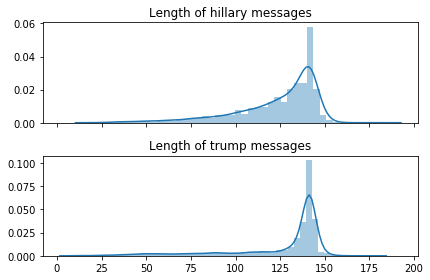

In [79]:
length_hillary = df_train[df_train['user'] == 'hillary'].len.values
length_trump = df_train[df_train['user'] == 'trump'].len.values
fig, axes = plt.subplots(nrows = 2, sharex= True)
sns.distplot(length_hillary, ax= axes[0]).\
set_title('Length of hillary messages')
sns.distplot(length_trump, ax = axes[1]).\
set_title('Length of trump messages')
plt.tight_layout()
plt.show()

In [80]:
hillary_words =  ''
trump_words = ''
array_label = df_train['user'].values
df_messages = df_train['token'].values

for idx in range(len(df_messages)):
    if array_label[idx] == 'hillary':
        hillary_words += '' + str(df_messages[idx])
    else:
        trump_words += '' + str(df_messages[idx])

In [81]:
from wordcloud import WordCloud
hillary_wordcloud = WordCloud(width=600, height=400).generate(hillary_words)
trump_wordcloud = WordCloud(width=600, height=400).generate(trump_words)

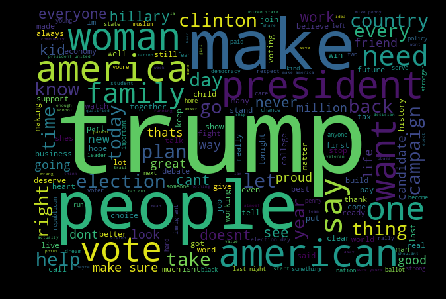

In [82]:
plt.figure( figsize=(6,5), facecolor='k')
plt.imshow(hillary_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

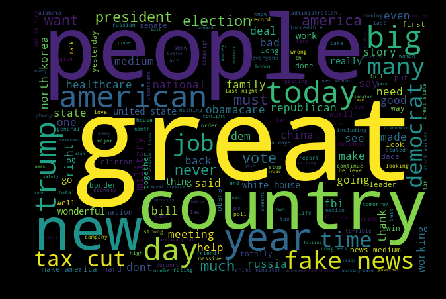

In [83]:
plt.figure( figsize=(6,5), facecolor='k')
plt.imshow(trump_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [84]:
Y_train = np.where(df_train.user == 'hillary', 1, 0)
message = df_train.token.values

In [85]:
kfold = KFold(n_splits = 5, shuffle = True, random_state=1234)

In [86]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score

# Count

In [87]:
count_vectorizer = CountVectorizer()
X_train = count_vectorizer.fit_transform(message)

In [88]:
print Y_train.shape
print X_train.shape

(6425,)
(6425, 8533)


In [89]:
log_count_model = LogisticRegressionCV()
log_count_score = cross_val_score(log_count_model,
                                  X_train, Y_train,
                                  scoring = 'accuracy',
                                  cv = kfold.split(X_train),
                                  n_jobs=-1).mean()
print log_count_score

0.8863813229571985


In [90]:
svc_count_model = LinearSVC()
svc_count_score = cross_val_score(svc_count_model,
                                  X_train, Y_train,
                                  scoring = 'accuracy',
                                  cv = kfold.split(X_train),
                                  n_jobs=-1).mean()
print svc_count_score

0.8806225680933852


In [91]:
nb_count_model = MultinomialNB()
nb_count_score = cross_val_score(nb_count_model, 
                                 X_train, Y_train,
                                 scoring = 'accuracy', 
                                 cv = kfold.split(X_train,),
                                 n_jobs=-1).mean()
print nb_count_score

0.9091050583657587


In [92]:
gb_count_model = GradientBoostingClassifier()
gb_count_score = cross_val_score(gb_count_model, 
                                 X_train, Y_train,
                                 scoring = 'accuracy', 
                                 cv = kfold.split(X_train),
                                 n_jobs=-1).mean()
print gb_count_score

0.7866147859922178


In [93]:
rf_count_model = RandomForestClassifier()
rf_count_score = cross_val_score(rf_count_model, 
                                 X_train, Y_train,
                                 scoring = 'accuracy', 
                                 cv = kfold.split(X_train),
                                 n_jobs=-1).mean()
print rf_count_score

0.8474708171206226


# TF-IDF

In [94]:
tfidf_vectorizer = TfidfVectorizer("english")
X_train = tfidf_vectorizer.fit_transform(message)

In [95]:
log_count_model = LogisticRegressionCV()
log_count_score = cross_val_score(log_count_model,
                                  X_train, Y_train,
                                  scoring = 'accuracy',
                                  cv = kfold.split(X_train),
                                  n_jobs=-1).mean()
print log_count_score

0.895408560311284


In [96]:
svc_count_model = LinearSVC()
svc_count_score = cross_val_score(svc_count_model,
                                  X_train, Y_train,
                                  scoring = 'accuracy',
                                  cv = kfold.split(X_train),
                                  n_jobs=-1).mean()
print svc_count_score

0.8982101167315175


In [97]:
nb_count_model = MultinomialNB()
nb_count_score = cross_val_score(nb_count_model, 
                                 X_train, Y_train,
                                 scoring = 'accuracy', 
                                 cv = kfold.split(X_train,),
                                 n_jobs=-1).mean()
print nb_count_score

0.9078599221789883


In [98]:
gb_count_model = GradientBoostingClassifier()
gb_count_score = cross_val_score(gb_count_model, 
                                 X_train, Y_train,
                                 scoring = 'accuracy', 
                                 cv = kfold.split(X_train),
                                 n_jobs=-1).mean()
print gb_count_score

0.7956420233463035


In [99]:
rf_count_model = RandomForestClassifier()
rf_count_score = cross_val_score(rf_count_model, 
                                 X_train, Y_train,
                                 scoring = 'accuracy', 
                                 cv = kfold.split(X_train),
                                 n_jobs=-1).mean()
print rf_count_score

0.8421789883268482


# Word2Vec - Glove

In [100]:
def w2v_to_features(w2v, list_tokens):
    w2v_keys = w2v.keys()
    n_dims = len(w2v[w2v.keys()[0]])
    result = np.zeros((len(list_tokens), n_dims))
    for idx in tqdm(range(len(list_tokens))):
        array_features = np.array([w2v[x] 
                                   for x in 
                                   list_tokens[idx] 
                                   if x in w2v_keys])
        if len(array_features) == 0:
            continue
        else:
            result[idx] = array_features.mean(axis = 0)
    return result.astype('float64')

In [101]:
with open('glove.twitter.27B.200d.txt', "rb") as lines:
    w2v = {line.split()[0]: 
                      np.array(map(float, line.split()[1:]))
               for line in lines}

In [ ]:
list_tokens = []
for idx in range(len(message)):
    list_tokens.append([str(x) for x in message[idx].split(' ')])

In [ ]:
scaler = MinMaxScaler()
X_train = w2v_to_features(w2v, list_tokens)
X_train = scaler.fit_transform(X_train)

 25%|██▌       | 1613/6425 [15:18<45:41,  1.76it/s]

In [ ]:
X_train.shape

In [ ]:
joblib.load(X_train, 'X_train_glove.pkl')

In [ ]:
log_count_model = LogisticRegressionCV()
log_count_score = cross_val_score(log_count_model,
                                  X_train, Y_train,
                                  scoring = 'accuracy',
                                  cv = kfold.split(X_train),
                                  n_jobs=-1).mean()
print log_count_score

In [ ]:
svc_count_model = LinearSVC()
svc_count_score = cross_val_score(svc_count_model,
                                  X_train, Y_train,
                                  scoring = 'accuracy',
                                  cv = kfold.split(X_train),
                                  n_jobs=-1).mean()
print svc_count_score

In [ ]:
nb_count_model = MultinomialNB()
nb_count_score = cross_val_score(nb_count_model, 
                                 X_train, Y_train,
                                 scoring = 'accuracy', 
                                 cv = kfold.split(X_train,),
                                 n_jobs=-1).mean()
print nb_count_score

In [ ]:
gb_count_model = GradientBoostingClassifier()
gb_count_score = cross_val_score(gb_count_model, 
                                 X_train, Y_train,
                                 scoring = 'accuracy', 
                                 cv = kfold.split(X_train),
                                 n_jobs=-1).mean()
print gb_count_score

In [ ]:
rf_count_model = RandomForestClassifier()
rf_count_score = cross_val_score(rf_count_model, 
                                 X_train, Y_train,
                                 scoring = 'accuracy', 
                                 cv = kfold.split(X_train),
                                 n_jobs=-1).mean()
print rf_count_score